This is a follow-up notebook from https://blog.paperspace.com/implementing-gans-in-tensorflow/

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## 1) Generating the real dataset

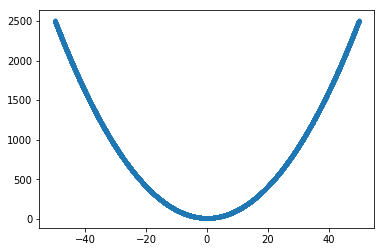

In [2]:
def get_y(x):
    return 10 + x**2

def sample_data(n=10000, scale=100):
    x = scale*(np.random.random_sample((n, ))-0.5)
    y = get_y(x)
    return np.array(list(zip(x,y)))

def sample_Z(m, n):
    return np.random.random_sample((m, n))

data = sample_data()
plt.plot(data.transpose()[0], data.transpose()[1], '.')
plt.show()

## 2) GAN definition

* $ G(Z) $ is the function that generates synthetic (fake) samples
* $ D(X) $ is the function that discriminates X for either being real or fake, outputs probability of real.

In [3]:
def generator(Z, hsize=[16, 16], reuse=False):
    with tf.variable_scope("GAN/Generator", reuse=reuse):
        h1 = tf.layers.dense(Z, hsize[0], activation=tf.nn.leaky_relu)
        h2 = tf.layers.dense(h1, hsize[1], activation=tf.nn.leaky_relu)
        out = tf.layers.dense(h2, 2)  # generate pairs (x,y) of synthetic data
    return out

def discriminator(X, hsize=[16, 16], reuse=False):
    with tf.variable_scope("GAN/Discriminator", reuse=reuse):
        h1 = tf.layers.dense(X, hsize[0], activation=tf.nn.leaky_relu)
        h2 = tf.layers.dense(h1, hsize[1], activation=tf.nn.leaky_relu)
        h3 = tf.layers.dense(h2, 2)  # logit, in 2D hyperspace, before logarithm
        out = tf.layers.dense(h3, 1)  # probability of real (P(x|x is real) = 1)
    return out, h3  # outputs of activation of last hidden layer to understand discriminator evolution

## 3) Building the GAN's graph

In [4]:
# variable placeholders
X = tf.placeholder(tf.float32, [None, 2])
Z = tf.placeholder(tf.float32, [None, 2])

# graph
G_sample = generator(Z)  # fake samples
r_logits, r_rep = discriminator(X)  # real samples discrimination
f_logits, f_rep = discriminator(G_sample, reuse=True)  # fake samples discrimination, it's the same discriminator so reuse

# loss functions
# discriminator loss is log(D(x)) + log(1-D(G(z)))
disc_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=r_logits, labels=tf.ones_like(r_logits)) +
                           tf.nn.sigmoid_cross_entropy_with_logits(logits=f_logits, labels=tf.zeros_like(f_logits)))
# generator loss is log(G(z))
gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=f_logits, labels=tf.ones_like(f_logits)))

# optimizers
# we collect the variables to be updated using scope and var_list
gen_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="GAN/Generator")
gen_step = tf.train.RMSPropOptimizer(learning_rate=0.0001).minimize(gen_loss, var_list=gen_vars)  # G train step
disc_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="GAN/Discriminator")
disc_step = tf.train.RMSPropOptimizer(learning_rate=0.0001).minimize(disc_loss, var_list=disc_vars)  # D train step

# train
batch_size = 1000
n_iter = 10000
with tf.Session() as sess:
    tf.global_variables_initializer().run(session=sess)
    for i in range(n_iter):
        X_batch = sample_data(n=batch_size)
        Z_batch = sample_Z(batch_size, 2)
        _, dloss = sess.run([disc_step, disc_loss], feed_dict={X:X_batch, Z:Z_batch})
        _, gloss = sess.run([gen_step,gen_loss], feed_dict={Z: Z_batch})
        print("Run {}, Generator loss = {}, Discriminator loss = {}".format(i, gloss, dloss))


Run 0, Generator loss = 0.6593821048736572, Discriminator loss = 0.728914201259613
Run 1, Generator loss = 0.6593763828277588, Discriminator loss = 0.7291349172592163
Run 2, Generator loss = 0.6596464514732361, Discriminator loss = 0.728754997253418
Run 3, Generator loss = 0.6597579717636108, Discriminator loss = 0.7287184000015259
Run 4, Generator loss = 0.6591467261314392, Discriminator loss = 0.7293239831924438
Run 5, Generator loss = 0.6598019003868103, Discriminator loss = 0.7286404967308044
Run 6, Generator loss = 0.6603962182998657, Discriminator loss = 0.7280246615409851
Run 7, Generator loss = 0.6606317162513733, Discriminator loss = 0.7276318073272705
Run 8, Generator loss = 0.6598705649375916, Discriminator loss = 0.7286645770072937
Run 9, Generator loss = 0.6603387594223022, Discriminator loss = 0.7280818223953247
Run 10, Generator loss = 0.6602166295051575, Discriminator loss = 0.728257417678833
Run 11, Generator loss = 0.6608555316925049, Discriminator loss = 0.7276085615